In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

from src.agoro_field_boundary_detector.augmentation import load_annotations, polygons_to_mask, transform
from src.agoro_field_boundary_detector.augmentation.transformations import t_linear, t_quartile, t_rotation, t_flip, t_blur, t_gamma

In [3]:
# Image to load
NAME = '3043'

In [4]:
# Load in field and mask
field = np.asarray(Image.open(Path.cwd() / f"data/imgs/{NAME}.jpeg"))
mask = np.asarray(Image.open(Path.cwd() / f"data/masks/{NAME}.png"))

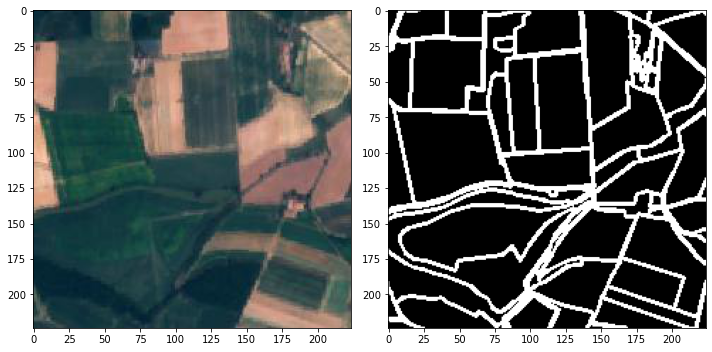

In [16]:
def show_image(field:np.ndarray, mask:np.ndarray):
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field)
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()
    
show_image(field, mask)

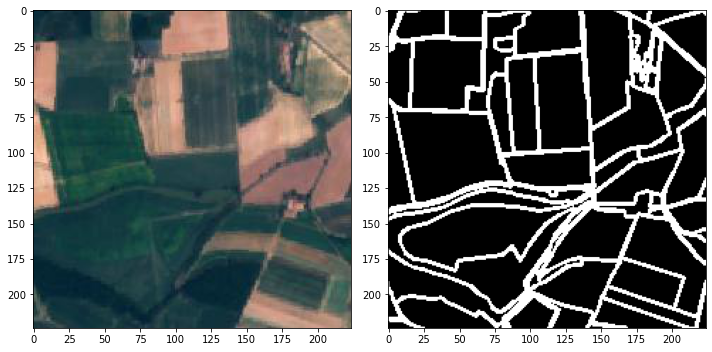

In [17]:
f,m = t_linear(field, mask)
show_image(f,m)

In [5]:
path = r'C:\Users\akinr\Downloads\crop_delineation\clean_data.csv'

import pandas as pd

df = pd.read_csv(path)
df.head(2)

,ids,indices,split,max_lat,max_lon,min_lat,min_lon
0,0,4813734,train,47.956223,2.055750,47.942745,2.035627
1,1,2521449,train,44.981155,5.026029,44.966919,5.005907


In [15]:
# names = df.indices

# names.to_csv(Path.cwd() / 'data/names.csv')

In [24]:
df.indices[df.split == 'train']

0        4813734
1        2521449
2       11061277
3        9752925
4        2856654
          ...   
1567      322031
1568     2945720
1569    10637836
1570     6132603
1571     2625033
Name: indices, Length: 1572, dtype: int64

In [26]:
prefixes = []
for i in df.indices[df.split == 'train']:
    prefixes.append(i)

In [25]:
import shutil
import os

shutil.os.mkdir("./data/train")
shutil.os.mkdir("./data/train_masks")
shutil.os.mkdir("./data/test")
shutil.os.mkdir("./data/test_masks")

a = df['indices'][df['split'] == 'train']
b = df['indices'][df['split'] == 'test']


for i in a:
    if os.path.exists(Path.cwd() / f"data/imgs/{i}.jpeg"):
        shutil.move(Path.cwd() / f"data/imgs/{i}.jpeg", Path.cwd() / f"data/train/{i}.jpeg")
for i in b:
    if os.path.exists(Path.cwd() / f"data/imgs/{i}.jpeg"):
        shutil.move(Path.cwd() / f"data/imgs/{i}.jpeg", Path.cwd() / f"data/test/{i}.jpeg")
for i in a:
    if os.path.exists(Path.cwd() / f"data/masks/{i}.png"):
        shutil.move(Path.cwd() / f"data/masks/{i}.png", Path.cwd() / f"data/train_masks/{i}.png")
for i in b:
    if os.path.exists(Path.cwd() / f"data/masks/{i}.png"):
        shutil.move(Path.cwd() / f"data/masks/{i}.png", Path.cwd() / f"data/test_masks/{i}.png")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './data/train'

In [ ]:
from shutil import rmtree
from typing import List
from tqdm import tqdm
from src.agoro_field_boundary_detector.augmentation import load_annotations, polygons_to_mask, transform
from src.agoro_field_boundary_detector.augmentation.transformations import get_random_noise, t_linear, t_quartile, t_rotation, t_flip, t_blur, t_gamma

In [ ]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    dupl: int = 2,
    prefix: str = "",
) -> None:
    """
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param dupl: Number of times to add random noise to the 5 translation augmentations
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    idx = 0
    for _ in range(dupl):
        for t, t_idx in (
            (t_linear, 0),
            (t_quartile, 0),
            (t_quartile, 1),
            (t_quartile, 2),
            (t_quartile, 3),
        ):
            n, n_idx = get_random_noise()
            field_t, mask_t = transform(
                field=field,
                mask=mask,
                translation=t,  # type: ignore
                t_idx=t_idx,
                noise=n,
                n_idx=n_idx,
            )
            # Save as PNG; slower but more memory efficient than pure numpy
            Image.fromarray(np.uint8(field_t)).save(write_folder / f"fields/{prefix}_{idx}.png")
            Image.fromarray(np.uint8(mask_t)).save(write_folder / f"masks/{prefix}_{idx}.png")
            idx += 1


In [27]:
# Load in the annotations
DATA_PATH = Path.cwd() / "data"
# annotations = load_annotations(DATA_PATH / "annotations.json")

# # Load in the requested coordinates, keep only training
# with open(DATA_PATH / "coordinates.json", "r") as f:
#     coordinates = json.load(f)
# coordinate_names = [f"{c[0]}-{c[1]}" for c in coordinates["train"]]
# names = [k for k in annotations.keys() if k in coordinate_names]
names = prefixes.copy()
# Load in fields and corresponding masks
annotated_fields, annotated_masks = [], []
for name in names:
    annotated_fields.append(np.asarray(Image.open(DATA_PATH / f"train/{name}.jpeg")))
    annotated_masks.append(np.asarray(Image.open(DATA_PATH / f"train_masks/{name}.png")))

# Ensure folders exist
if (DATA_PATH / "augmented").is_dir():
    rmtree(DATA_PATH / "augmented")
(DATA_PATH / "augmented/fields").mkdir(exist_ok=True, parents=True)
(DATA_PATH / "augmented/masks").mkdir(exist_ok=True, parents=True)
write_folder=DATA_PATH / "augmented"

for field, mask, prefix in tqdm(
        zip(annotated_fields, annotated_masks, prefixes), total=len(prefixes), desc="Generating"
    ):
        generate(
            field=field,
            mask=mask,
            prefix=prefix,
            dupl=2,
            write_folder=write_folder,
        )

Generating: 100%|██████████| 1572/1572 [08:08<00:00,  3.22it/s]


In [4]:
!python src/agoro_field_boundary_detector/iii_train_mask_rcnn.py

Traceback (most recent call last):
  File "c:\Users\akinr\Desktop\GitHub\agoro-field-boundary-detector\src\agoro_field_boundary_detector\iii_train_mask_rcnn.py", line 6, in <module>
    from field_detection import Dataset, FieldBoundaryDetector
  File "c:\Users\akinr\Desktop\GitHub\agoro-field-boundary-detector\src\agoro_field_boundary_detector\field_detection\__init__.py", line 3, in <module>
    from .model import FieldBoundaryDetector
  File "c:\Users\akinr\Desktop\GitHub\agoro-field-boundary-detector\src\agoro_field_boundary_detector\field_detection\model.py", line 24, in <module>
    from field_detection.mask_rcnn_model import MaskRCNN
  File "c:\Users\akinr\Desktop\GitHub\agoro-field-boundary-detector\src\agoro_field_boundary_detector\field_detection\mask_rcnn_model.py", line 24, in <module>
    from utils import *
ModuleNotFoundError: No module named 'utils'
